In [1]:
import pandas as pd

In [2]:
import geopandas as gp

In [3]:
import numpy as np

In [4]:
import xml.etree.ElementTree as ET
from xml.etree.ElementTree import Element
# from lxml import etree
from copy import copy
import os
import inspect
from xml.dom import minidom

In [5]:
import math

In [6]:
import networkx as nx

In [7]:
from networkx import DiGraph

In [8]:
from vrpy import VehicleRoutingProblem

In [9]:
import matplotlib.pyplot as plt 

In [10]:
# TODO: What if source and destination block zone are in the same TAZ?
# Handle case when block-level zone cannot be mapped to correct TAZ
# TODO: Handle multiple shipments/routes per carrier, having multiple sequence ids

### Function to create graph for carrier tour problem

In [11]:
# The first step is to create a graph for each carrier depending on its delivery/pickup location and depo locations
# This function receives as input, a data frame with payload for the carrier of interest, a data frame on the carrier
# of interest, the depot location, 
# Input parameters:
    # db_prob: section of payloads.csv dataframe corresponding to carrier with carrier_id
    # carrier_id: carrier id of interest
    # c_prob: section of carriers.cs dataframe corresponding to carrier with carrier_id
    # depot_loc: depot zone for carrier carrier_id
    # fleet_type: whether fleet is homogeneous or heterogeneous
    # tt_df: taz to taz travel time data frame
def create_graph(df_prob, carr_id, c_prob, depot_loc, fleet_type, CBGzone_df,dist_df, tt_df):
    # Create an empty Directed graph and add the depot as source and sink to the digraph
    g = DiGraph()
    payload_nodes = dict()    # nodes associate with each payload id
    distance = dict()
    node_list = []
    missing_taz = False
    
    # Adding Nodes
    n = 1   # Node ids
    for i in df_prob['payload_id'].unique(): # Can we assume that payload id's are unique?
        if str(df_prob.loc[df_prob['payload_id'] == i]['job'].values[0]) != 'pickup_delivery':
            if str(df_prob.loc[df_prob['payload_id'] == i]['job'].values[0]) == 'delivery':
                temp_zone = (int(df_prob.loc[df_prob['payload_id'] == i]['del_zone'].values[0]))
            elif str(df_prob.loc[df_prob['payload_id'] == i]['job'].values[0]) =='pickup':
                temp_zone = (int(df_prob.loc[df_prob['payload_id'] == i]['pu_zone'].values[0]))
                
#             # We are adding cbg_ids as nodes and not taz ids anymore
            g.add_node(temp_zone)
#             pos[n] = copy(temp_pos)
            payload_nodes[i] = temp_zone
#             print("i is ", i)
            n = n + 1

        else:
            temp_del = int(df_prob.loc[df_prob['payload_id'] == i]['del_zone'].values[0])
            temp_pick = int(df_prob.loc[df_prob['payload_id'] == i]['pu_zone'].values[0])
            
            # Adding pick-up node
            g.add_node(temp_pick)
            payload_nodes[i] = [temp_pick]
            n = n + 1
            
            # Adding drop-off node    
            g.add_node(temp_del)
            payload_nodes[i].append(temp_del)
            n = n + 1
                
    # Now completing the creation of the graph
    # Do below only if there are no missing data
    if not missing_taz:
        if any(isinstance(i, list) for i in list(payload_nodes.values())):
            node_list = [item for sublist in list(payload_nodes.values()) for item in sublist]
        else:
            node_list = list(payload_nodes.values())

#         print("node values: ", node_list)
        g = nx.complete_graph(node_list, create_using=None)
        g = g.to_directed()
        
        # Adding source and sink
        g.add_node("Source")
        # Sink location is same as depo 
        g.add_node("Sink")

        # Adding edge costs
        if fleet_type =='hete':
            print('hetegeneous fleet')
            # Determine number of vehicle types
            num_veh_types = sum('num_veh_type_' in s for s in c_prob.columns)
            print('number of vehicle types = ', num_veh_types)
            for edge in g.edges():
                startnode=edge[0] 
                endnode=edge[1]
                try:
                    dist_cost = tt_cal(startnode, endnode) # KJ: find travel time using tt_cal function
                except Exception as e:
                    dist_cost = 1*5.0   # We assume 3 hours if we do not have travel time
                    
                # We assume same travel time for medium and heavy duty vehicles, this can change in future
                # We assume medium and heavy duty vehicles for now
                g[startnode][endnode]['cost']= [dist_cost, dist_cost] # This should be probably be related to time window
                distance[(startnode,endnode)] = dist_cost
#                 print("I get here, dist_cost ", dist_cost)

        else:
            print('homogeneous fleet')
            for edge in g.edges():
                startnode=edge[0] 
                endnode=edge[1]
                try:
                    dist_cost = tt_cal(startnode, endnode)  # KJ: find travel time using tt_cal function
                except Exception as e:
                    dist_cost = 1*5.0   # We assume 3 hours if we do not have travel time
                g[startnode][endnode]["cost"]= dist_cost # This should be probably be related to time window
                distance[(startnode,endnode)] = dist_cost
                print("I get here, dist_cost: ", dist_cost)

        for n in node_list:  # Can we assume that payload id's are unique?
            # Add edge to source and sink
            try:
                dist_source = tt_cal(depot_taz, n)  # KJ: find travel time using tt_cal function
            except Exception as e:
                print("could not find travel time")
                dist_source = 1*5.0

            try:
                dist_sink = float(tt_df.loc[(tt_df['origTaz'] == n) & (tt_df['destTaz'] == depot_taz)
                          & (tt_df['mode'] == 'CAR')]['travelTimeInS'].values[0])/60.0
            except Exception as e:
                print("could not find travel time")
                dist_sink = 3*60.0

            if fleet_type == 'hete':
    #             print("dist_sink ", dist_sink, " dist_source ", dist_source)
                g.add_edge(n, "Sink", cost=[dist_sink, dist_sink])
                g.add_edge("Source", n, cost=[dist_source, dist_source])
            else:
                g.add_edge(n, "Sink", cost= dist_sink)
                g.add_edge("Source", n, cost= dist_source)

            distance[('Source',n)] = dist_source
            distance[(n,'Sink')] = dist_sink
    
    return g, payload_nodes, distance, missing_taz

### Function to add demand to problem

In [12]:
# Function to add the demand on the network graph for the problem
# Input parameters:
    # df_prob: section of payloads.csv dataframe corresponding to carrier with carrier_id
    # g: tour graph for carrier id of interest
    # payloads: dictionary of payload ids to nodes (which payload ids corresponds to which demand node)
### KJ: I added c_prob in "add_demand" function because we need to have lower and upper bound for source/sink node;
### : see the description at reading carrier file below
def add_demand(df_prob, c_prob, g, payload_nodes):
    prob_type = ''
    
    ### KJ: adding time window and service time
    carr_id =df_prob['carrier_id'].unique()[0]
    g.nodes['Source']["lower"]=float(c_prob.loc[c_prob['carrier_id'] == carr_id]['depot_lower'].values[0])
    g.nodes['Source']["upper"]=float(c_prob.loc[c_prob['carrier_id'] == carr_id]['depot_upper'].values[0])
    g.nodes['Sink']["lower"]=float(c_prob.loc[c_prob['carrier_id'] == carr_id]['depot_lower'].values[0])
    g.nodes['Sink']["upper"]=float(c_prob.loc[c_prob['carrier_id'] == carr_id]['depot_upper'].values[0])
    g.nodes['Source']["service_time"]=float(c_prob.loc[c_prob['carrier_id'] == carr_id]['depot_time_before'].values[0])
    g.nodes['Sink']["service_time"]=float(c_prob.loc[c_prob['carrier_id'] == carr_id]['depot_time_after'].values[0])
    
    for i in df_prob['payload_id'].unique(): 
        if str(df_prob.loc[df_prob['payload_id'] == i]['job'].values[0]) != 'pickup_delivery':
            # Add demand for delivery
            demand = int(df_prob.loc[df_prob['payload_id'] == i]['weight'].values[0])
            g.nodes[payload_nodes[i]]["demand"] = demand
#             print("pick-del demand is: ", demand)
            
            # Adding stop duration and time window for delivery and pickup
            if str(df_prob.loc[df_prob['payload_id'] == i]['job'].values[0]) == 'delivery':
                # Adding time window and service time if they exist
                g.nodes[payload_nodes[i]]["lower"] = float(df_prob.loc[df_prob['payload_id'] == i]['del_tw_lower'].values[0])
                g.nodes[payload_nodes[i]]["upper"] = float(df_prob.loc[df_prob['payload_id'] == i]['del_tw_upper'].values[0])
                g.nodes[payload_nodes[i]]["service_time"] = float(df_prob.loc[df_prob['payload_id'] == i]['del_stop_duration'].values[0])
                prob_type = 'delivery'
            elif str(df_prob.loc[df_prob['payload_id '] == i]['job'].values[0]) =='pickup':
                g.nodes[payload_nodes[i]]["lower"] = float(df_prob.loc[df_prob['payload_id '] == i]['pu_tw_lower'].values[0])
                g.nodes[payload_nodes[i]]["upper"] = float(df_prob.loc[df_prob['payload_id '] == i]['pu_tw_upper'].values[0])
                g.nodes[payload_nodes[i]]["service_time"] = float(df_prob.loc[df_prob['payload_id '] == i]['pu_stop_duration'].values[0])
                prob_type = 'pickup'
        else:
            # TO DO this need to be fixed/looked at: what if you have multible delivery/pickup in same location
            # So far what I have seen is that a node with multiple demand is divided into multiple locations
            #Adding pick up demand
            pick_node = int(payload_nodes[i][0])
            del_node = int(payload_nodes[i][1])
            g.nodes[pick_node]["request"] = del_node
            demand = int(df_prob.loc[df_prob['payload_id'] == i]['weight'].values[0]);
#             demand = 5
            g.nodes[pick_node]["demand"] = copy(demand)
#             print("pick_node ", pick_node, "del_node ", del_node, "demand ", demand)
            # It is a pick-delivery process
            l_w = float(df_prob.loc[df_prob['payload_id'] == i]['pu_tw_lower'].values[0])
            u_w = float(df_prob.loc[df_prob['payload_id'] == i]['pu_tw_upper'].values[0])
            s_w = float(df_prob.loc[df_prob['payload_id'] == i]['pu_stop_duration'].values[0])
#             print( "l_w ", l_w, " u_w ", u_w, " s_w ", s_w)
            g.nodes[pick_node]["lower"] = float(df_prob.loc[df_prob['payload_id'] == i]['pu_tw_lower'].values[0])
            g.nodes[pick_node]["upper"] = float(df_prob.loc[df_prob['payload_id'] == i]['pu_tw_upper'].values[0])
#             g.nodes[pick_node]["upper"] = 86400.0
            g.nodes[pick_node]["service_time"] = float(df_prob.loc[df_prob['payload_id'] == i]['pu_stop_duration'].values[0])
            
            # Adding delivery demand
            g.nodes[del_node]["demand"] = -1* demand
            l_w = float(df_prob.loc[df_prob['payload_id'] == i]['del_tw_lower'].values[0])
            u_w = float(df_prob.loc[df_prob['payload_id'] == i]['del_tw_upper'].values[0])
            s_w = float(df_prob.loc[df_prob['payload_id'] == i]['del_stop_duration'].values[0])
#             print( "l_w ", l_w, " u_w ", u_w, " s_w ", s_w)
                  
            # It is a pick-delivery process
            g.nodes[del_node]["lower"] = float(df_prob.loc[df_prob['payload_id'] == i]['del_tw_lower'].values[0])
            g.nodes[del_node]["upper"] = float(df_prob.loc[df_prob['payload_id'] == i]['del_tw_upper'].values[0])
#             g.nodes[del_node]["service_time"] = 86400.0
            g.nodes[del_node]["service_time"] = float(df_prob.loc[df_prob['payload_id'] == i]['del_stop_duration'].values[0])
            prob_type = 'pickup_delivery'
            
    return prob_type

In [13]:
# Function to get travel time using mesozone ID refering CBGID in tt_df
def tt_cal(org_meso, dest_meso):
    try:
        org_geoID= int(CBGzone_df[CBGzone_df['MESOZONE']==org_meso].GEOID.values[0])
        dest_geoID= int(CBGzone_df[CBGzone_df['MESOZONE']==dest_meso].GEOID.values[0])
        return tt_df[(tt_df['origin']==org_geoID) & (tt_df['destination']==dest_geoID)].TIME_minutes.values[0]
    except:
        dist = dist_df[(dist_df['Origin']==org_meso) & (dist_df['Destination']==dest_meso)].dist.values[0]
        return dist/40*60
# Function to create coorinate info after having the results 
def x_y_finder(meso):
    try:
        find_index=CBGzone_df.index[CBGzone_df['MESOZONE']==meso]
        x_cord= CBGzone_df.iloc[find_index].X_cord.values[0]
        y_cord= CBGzone_df.iloc[find_index].Y_cord.values[0]
        return x_cord, y_cord
    except:
        return "NA", "NA"

### Running the VRP Problems

In [14]:
# KJ: read travel time, distance, zonal file as inputs
tt_df = pd.read_csv('input_file/tt_df_cbg.csv.gz', compression='gzip', header=0, sep=',', quotechar='"', error_bad_lines=False)
dist_df = pd.read_csv('input_file/od_distance.csv')
CBGzone_df = gp.read_file('input_file/freight_centroids.geojson')

In [15]:
# taz_df = gp.read_file('input_file/TAZs/tazs_with_ids.shp')

In [16]:
# taz_df.head()

In [17]:
# taz_df['cbg_ids'] = '-' + taz_df['cbg_ids'] + '-'

In [18]:
# taz_df.head()

In [19]:
# len(taz_df)

In [20]:
# taz_df[taz_df['taz1454']==565]['cbg_ids'].values

In [21]:
# We need to know the depot using the carrier file
c_df = pd.read_csv('input_file/carriers.csv')
### KJ: TO DO: 1 need to add lower and upper timewindow and servicetime in the carrier file: 
###            'depot_lower', "depot_upper", "depot_time_before", "depot_time_after"
### KJ: lower will be used for Source's departure time, and upper will be used for sink's arrival time 
### KJ: need to include service time at depot? How to define the service time? Based on commodity and load? 
c_df = c_df.dropna(axis=1, how='all')   # Removing all nan

# reading payload definition
p_df = pd.read_csv('input_file/payloads.csv')
p_df = p_df.dropna(axis=1, how='all')   # Removing all nan

In [22]:
# # We need to know the depot using the carrier file
# c_df = pd.read_csv('input_file/carriers.csv')
# c_df = c_df.dropna(axis=1, how='all')   # Removing all nan

# # reading payload definition
# p_df = pd.read_csv('input_file/payloads.csv')
# p_df = p_df.dropna(axis=1, how='all')   # Removing all nan

In [23]:
# just relax upper time window because of outside of region destination 
c_df['depot_upper']=50000
p_df['del_tw_upper']=50000

In [24]:
c_df.head()

,carrier_id,firm_id,depot_zone,contract_firms,num_veh_type_1,num_veh_type_2,depot_lower,depot_upper,depot_time_before,depot_time_after
0,692698,692698,761,[692698.0],2,6,540,50000,5,10
1,732013,732013,85,[732013.0],2,9,700,50000,5,15
2,732036,732036,370,[732036.0],4,6,520,50000,5,25
3,732042,732042,919,[732042.0],5,10,520,50000,0,15
4,749269,749269,604,[749269.0],4,9,640,50000,5,15


In [25]:
# Adding in additional colums for vehicle tours

In [26]:
p_df['carrier_id'] = p_df['carrier_id'].astype(int)

In [27]:
p_df['sequence_id'] = np.nan

In [28]:
p_df['tour_id'] = np.nan

In [29]:
p_df['pu_arrival_time'] = np.nan

In [30]:
p_df['del_arrival_time'] = np.nan

In [31]:
p_df = p_df.fillna(int(0));

In [32]:
p_df.head()

,payload_id,carrier_id,commodity,weight,job,pu_zone,del_zone,pu_stop_duration,del_stop_duration,pu_tw_lower,pu_tw_upper,del_tw_lower,del_tw_upper,sequence_id,tour_id,pu_arrival_time,del_arrival_time
0,0,692698,3,1.3200,delivery,0.0,313,0.0,9,0.0,0.0,300,50000,0.0,0.0,0.0,0.0
1,1,732013,4,1.2055,delivery,0.0,20009,0.0,18,0.0,0.0,300,50000,0.0,0.0,0.0,0.0
2,2,732036,4,2.2500,delivery,0.0,20011,0.0,10,0.0,0.0,300,50000,0.0,0.0,0.0,0.0
3,3,732042,4,3.7775,delivery,0.0,20114,0.0,13,0.0,0.0,300,50000,0.0,0.0,0.0,0.0
4,4,749269,4,7.0095,delivery,0.0,328,0.0,7,0.0,0.0,300,50000,0.0,0.0,0.0,0.0


In [33]:
# Changing tour id and sequence id into ints
p_df['tour_id'] = p_df['tour_id'].astype(int)
p_df['sequence_id'] = p_df['sequence_id'].astype(int)

In [34]:
p_df.head()

,payload_id,carrier_id,commodity,weight,job,pu_zone,del_zone,pu_stop_duration,del_stop_duration,pu_tw_lower,pu_tw_upper,del_tw_lower,del_tw_upper,sequence_id,tour_id,pu_arrival_time,del_arrival_time
0,0,692698,3,1.3200,delivery,0.0,313,0.0,9,0.0,0.0,300,50000,0,0,0.0,0.0
1,1,732013,4,1.2055,delivery,0.0,20009,0.0,18,0.0,0.0,300,50000,0,0,0.0,0.0
2,2,732036,4,2.2500,delivery,0.0,20011,0.0,10,0.0,0.0,300,50000,0,0,0.0,0.0
3,3,732042,4,3.7775,delivery,0.0,20114,0.0,13,0.0,0.0,300,50000,0,0,0.0,0.0
4,4,749269,4,7.0095,delivery,0.0,328,0.0,7,0.0,0.0,300,50000,0,0,0.0,0.0


In [35]:
# Reading in vehicle information
v_df = pd.read_csv('input_file/vehicle_types.csv')
v_df = v_df.dropna(axis=1, how='all')   # Removing all nan

In [36]:
v_df.head()

,veh_type_id,veh_category,commodities,weight,payload_capacity_weight
0,1,MD,"[1, 2, 3, 4]",10000,5000
1,2,HD,"[1, 2, 3, 4]",20000,15000


In [37]:
vc_df = pd.read_csv('input_file/vehicles_by_carrier.csv')

In [38]:
vc_df.head()

,Unnamed: 0,carrier_id,md_veh,hd_veh,md_start_id,hd_start_id
0,0,45,3,9,0,3
1,1,46,3,10,12,15
2,2,47,5,7,25,30
3,3,48,3,9,37,40
4,4,49,9,8,49,58


In [39]:
vc_df.columns

Index(['Unnamed: 0', 'carrier_id', 'md_veh', 'hd_veh', 'md_start_id',
       'hd_start_id'],
      dtype='object')

In [40]:
# tt_df = pd.read_csv('input_file/15.skims.csv')

In [41]:
# tt_df.head()

In [42]:
# tt_df['mode'].unique()

In [43]:
c_df = c_df.fillna(0); # Fill all nan with zeros

In [44]:
p_df['carrier_id'].unique()

array([ 692698,  732013,  732036, ..., 2273352, 2248475, 2273250])

In [45]:
g = DiGraph()

### Creating the output dataframe to save as csv

In [46]:
tour_id = 0

In [47]:
tour_df = pd.DataFrame(columns = ['tour_id', 'veh_id', 'start_time', 'start_zone'])

In [48]:
for carr_id in c_df['carrier_id'].unique(): #p_df['carrier_id'].unique():
# for carr_id in [2248090]:
#     print("carrier id is: ", carr_id)
    
    # Initialize parameters used for probelm setting
    veh_capacity = 0
    fleet_type = 'homo'
    num_veh = 0
    fleet_miz = False
    
    #TO DO: when origin and destination zone fall in the same TAZ zone
    
    # Otherwise we use the depot_zone for location
    depot_loc = c_df.loc[c_df['carrier_id'] == carr_id]['depot_zone'].values[0]
    
    # To simplify the problem, look at a small problem with same carrier and same commodity id
    df_prob = p_df[(p_df['carrier_id'] == carr_id)]
    f_prob = vc_df[vc_df['carrier_id'] == carr_id]
    c_prob = c_df[c_df['carrier_id'] == carr_id]
#     print("df_prob ", len(df_prob), " f_prob ", len(f_prob), " c_prob ", len(c_prob))
    
    if len(df_prob) > 0 and len(f_prob) > 0 and len(c_prob) > 0:    
        missing_taz = True

        # Drop nan's columns
        df_prob = df_prob.dropna(axis=1, how='all')

        # Check if the carrier has homogeneous fleet to formulate a homogeneous fleet problem
        # This happens if the carrier only has medium duty vehicles or heavy duty vehicles
    #     if len(f_prob['veh_type_id'].unique()) == 1:
        if(f_prob['md_veh'].values[0] == 0 or f_prob['hd_veh'].values[0] == 0):
            print("\nNew Problem: Solving Homogeneous fleet Problem for Carrier ", carr_id)
            fleet_type = 'homo'     

            # We assume first value in graph is medium duty and second is duty
            if f_prob['md_veh'].values[0] == 0:
                veh_capacity = int(v_df[v_df['veh_category'] == 'HD']['payload_capacity_weight'].values[0])
                num_veh = f_prob['hd_veh'].values[0]
            else:
                veh_capacity = int(v_df[v_df['veh_category'] == 'MD']['payload_capacity_weight'].values[0])
                num_veh = f_prob['md_veh'].values[0]

    #         print("veh_capacity: ", veh_capacity, " num_veh: ", num_veh)
            fleet_mix = False

        else:
            print("\nNew Problem: Solving problem with heterogeneous fleet for carrier ", carr_id)
            fleet_type = 'hete'

            # We assume first value in graph is medium duty and second is duty
            veh_capacity = [int(v_df[v_df['veh_category'] == 'MD']['payload_capacity_weight'].values[0]),
                            int(v_df[v_df['veh_category'] == 'HD']['payload_capacity_weight'].values[0])]
            num_veh = [f_prob['md_veh'].values[0], f_prob['hd_veh'].values[0]]
            print("veh_capacity: ", veh_capacity, " num_veh: ", num_veh)
            fleet_mix = True

        g, payload_nodes, distance, missing_taz = create_graph(df_prob, carr_id, c_prob, depot_loc, fleet_type, CBGzone_df,dist_df, tt_df)

        if not missing_taz:
            # adding demand to problem
            prob_type = add_demand(df_prob, c_prob, g, payload_nodes)
            # Add remaining problem parameters
#             print('prob param: veh_cap ', veh_capacity, ' num_vehicles ', num_veh, ' mixed_fleet ', fleet_mix)
            prob = VehicleRoutingProblem(g, load_capacity = veh_capacity, num_vehicles = num_veh, 
                                         time_windows = True, mixed_fleet = fleet_mix)

            if prob_type == 'pickup_delivery':
                prob.pickup_delivery = True
            try:
                print("Problem type: ", prob_type)
                if prob_type == 'pickup_delivery':
                    prob.solve(cspy=False, time_limit=60)
                else:
                    prob.solve(time_limit=60)

                print("Best routes: ", prob.best_routes)
                print("Route departure: ", prob.departure_time)
                print("Route cost: ", prob.best_routes_cost)
                print("Route type: ", prob.best_routes_type )
                print("Route arrival: ", prob.arrival_time)
                print("Route Load: ", prob.best_routes_load)

                # Adding results to the payload dataframe
                if len(df_prob) == 1 and len(prob.best_routes.values()) == 1 :  # If it is a problem with just one payload
                    if prob.best_routes_type[1] == 0:
                        veh_id = vc_df[vc_df['carrier_id']== carr_id]['md_start_id'].values[0]
                    else:
                        veh_id = vc_df[vc_df['carrier_id']== carr_id]['hd_start_id'].values[0]

                    start_time = list(prob.departure_time.values())[0]['Source']
    #                     print("Adding: ", tour_id, " ", veh_id, " ", start_time, " ", depot_loc)
                    tour_df.loc[tour_id] = [tour_id, veh_id, start_time, depot_loc]
                    carr_filter = (p_df['carrier_id'] == carr_id)
                    sequence_id = 1;
                    p_df.loc[carr_filter,['tour_id']] = tour_id
                    p_df.loc[carr_filter, ['sequence_id']] = sequence_id
                    tour_id +=1
                    if prob_type == 'delivery':
                        delivery_time = list(prob.arrival_time.values())[0][list(payload_nodes.values())[0]]
                        p_df.loc[carr_filter,['del_arrival_time']] = delivery_time
                    elif prob_type == 'pickup':
                        pickup_time = list(prob.arrival_time.values())[0][list(payload_nodes.values())[0]]
                        p_df.loc[carr_filter,['pu_arrival_time']] = pickup_time

            except Exception as e:
                print("Problem did not solve:", e)

INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:iteration 0, 185.0
INFO:vrpy.master_solve_pulp:total cost = 185.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:iteration 0, 185.0



New Problem: Solving problem with heterogeneous fleet for carrier  692698
veh_capacity:  [5000, 15000]  num_veh:  [7, 5]
hetegeneous fleet
number of vehicle types =  2
could not find travel time
could not find travel time
Problem type:  delivery
Best routes:  {1: ['Source', 313, 'Sink']}
Route departure:  {1: {'Source': 540.0, 313: 554.0, 'Sink': 564.0}}
Route cost:  {1: 185.0}
Route type:  {1: 0}
Route arrival:  {1: {'Source': 540.0, 313: 545.0, 'Sink': 554.0}}
Route Load:  {1: 1}

New Problem: Solving problem with heterogeneous fleet for carrier  732013
veh_capacity:  [5000, 15000]  num_veh:  [3, 3]
hetegeneous fleet
number of vehicle types =  2
could not find travel time
could not find travel time
Problem type:  delivery


INFO:vrpy.master_solve_pulp:total cost = 185.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:iteration 0, 185.0
INFO:vrpy.master_solve_pulp:total cost = 185.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:iteration 0, 185.0


Best routes:  {1: ['Source', 20009, 'Sink']}
Route departure:  {1: {'Source': 700.0, 20009: 723.0, 'Sink': 738.0}}
Route cost:  {1: 185.0}
Route type:  {1: 0}
Route arrival:  {1: {'Source': 700.0, 20009: 705.0, 'Sink': 723.0}}
Route Load:  {1: 1}

New Problem: Solving problem with heterogeneous fleet for carrier  732036
veh_capacity:  [5000, 15000]  num_veh:  [4, 9]
hetegeneous fleet
number of vehicle types =  2
could not find travel time
could not find travel time
Problem type:  delivery
Best routes:  {1: ['Source', 20011, 'Sink']}
Route departure:  {1: {'Source': 520.0, 20011: 535.0, 'Sink': 560.0}}
Route cost:  {1: 185.0}
Route type:  {1: 0}
Route arrival:  {1: {'Source': 520.0, 20011: 525.0, 'Sink': 535.0}}
Route Load:  {1: 2}

New Problem: Solving problem with heterogeneous fleet for carrier  732042
veh_capacity:  [5000, 15000]  num_veh:  [4, 7]
hetegeneous fleet
number of vehicle types =  2
could not find travel time
could not find travel time
Problem type:  delivery


INFO:vrpy.master_solve_pulp:total cost = 185.0


Best routes:  {1: ['Source', 20114, 'Sink']}
Route departure:  {1: {'Source': 520.0, 20114: 533.0, 'Sink': 548.0}}
Route cost:  {1: 185.0}
Route type:  {1: 0}
Route arrival:  {1: {'Source': 520.0, 20114: 520.0, 'Sink': 533.0}}
Route Load:  {1: 3}

New Problem: Solving problem with heterogeneous fleet for carrier  749269
veh_capacity:  [5000, 15000]  num_veh:  [3, 4]
hetegeneous fleet
number of vehicle types =  2


INFO:vrpy.vrp:new upper bound : max num stops = 4
INFO:vrpy.vrp:iteration 0, 370.0
INFO:vrpy.master_solve_pulp:total cost = 370.0


could not find travel time
could not find travel time
could not find travel time
could not find travel time
Problem type:  delivery
Best routes:  {1: ['Source', 328, 'Sink'], 2: ['Source', 20122, 'Sink']}
Route departure:  {1: {'Source': 640.0, 328: 652.0, 'Sink': 667.0}, 2: {'Source': 640.0, 20122: 655.0, 'Sink': 670.0}}
Route cost:  {1: 185.0, 2: 185.0}
Route type:  {1: 0, 2: 0}
Route arrival:  {1: {'Source': 640.0, 328: 645.0, 'Sink': 652.0}, 2: {'Source': 640.0, 20122: 645.0, 'Sink': 655.0}}
Route Load:  {1: 7, 2: 0}

New Problem: Solving problem with heterogeneous fleet for carrier  751485
veh_capacity:  [5000, 15000]  num_veh:  [5, 7]
hetegeneous fleet
number of vehicle types =  2
could not find travel time
could not find travel time
Problem type: 

INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:iteration 0, 185.0
INFO:vrpy.master_solve_pulp:total cost = 185.0
INFO:vrpy.vrp:new upper bound : max num stops = 3


 delivery
Best routes:  {1: ['Source', 20115, 'Sink']}
Route departure:  {1: {'Source': 520.0, 20115: 549.0, 'Sink': 569.0}}
Route cost:  {1: 185.0}
Route type:  {1: 0}
Route arrival:  {1: {'Source': 520.0, 20115: 540.0, 'Sink': 549.0}}
Route Load:  {1: 0}

New Problem: Solving problem with heterogeneous fleet for carrier  757288
veh_capacity:  [5000, 15000]  num_veh:  [5, 14]
hetegeneous fleet
number of vehicle types =  2
could not find travel time
could not find travel time
Problem type:  delivery


INFO:vrpy.vrp:iteration 0, 185.0
INFO:vrpy.master_solve_pulp:total cost = 185.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:iteration 0, 185.0
INFO:vrpy.master_solve_pulp:total cost = 185.0


Best routes:  {1: ['Source', 7967, 'Sink']}
Route departure:  {1: {'Source': 500.0, 7967: 535.0, 'Sink': 555.0}}
Route cost:  {1: 185.0}
Route type:  {1: 0}
Route arrival:  {1: {'Source': 500.0, 7967: 515.0, 'Sink': 535.0}}
Route Load:  {1: 1}

New Problem: Solving Homogeneous fleet Problem for Carrier  766771
homogeneous fleet
could not find travel time
could not find travel time
Problem type:  delivery
Best routes:  {1: ['Source', 20009, 'Sink']}
Route departure:  {1: {'Source': 520.0, 20009: 541.0, 'Sink': 551.0}}
Route cost:  {1: 185.0}
Route type:  {1: 0}
Route arrival:  {1: {'Source': 520.0, 20009: 525.0, 'Sink': 541.0}}
Route Load:  {1: 1}


INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:iteration 0, 185.0



New Problem: Solving problem with heterogeneous fleet for carrier  795227
veh_capacity:  [5000, 15000]  num_veh:  [5, 10]
hetegeneous fleet
number of vehicle types =  2
could not find travel time
could not find travel time
Problem type:  delivery


INFO:vrpy.master_solve_pulp:total cost = 185.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:iteration 0, 185.0
INFO:vrpy.master_solve_pulp:total cost = 185.0


Best routes:  {1: ['Source', 20092, 'Sink']}
Route departure:  {1: {'Source': 580.0, 20092: 599.0, 'Sink': 624.0}}
Route cost:  {1: 185.0}
Route type:  {1: 0}
Route arrival:  {1: {'Source': 580.0, 20092: 580.0, 'Sink': 599.0}}
Route Load:  {1: 0}

New Problem: Solving problem with heterogeneous fleet for carrier  801094
veh_capacity:  [5000, 15000]  num_veh:  [4, 12]
hetegeneous fleet
number of vehicle types =  2
could not find travel time
could not find travel time
Problem type:  delivery
Best routes: 

INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:iteration 0, 185.0
INFO:vrpy.master_solve_pulp:total cost = 185.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:iteration 0, 185.0


 {1: ['Source', 20009, 'Sink']}
Route departure:  {1: {'Source': 660.0, 20009: 699.0, 'Sink': 714.0}}
Route cost:  {1: 185.0}
Route type:  {1: 0}
Route arrival:  {1: {'Source': 660.0, 20009: 685.0, 'Sink': 699.0}}
Route Load:  {1: 1}

New Problem: Solving problem with heterogeneous fleet for carrier  815836
veh_capacity:  [5000, 15000]  num_veh:  [2, 12]
hetegeneous fleet
number of vehicle types =  2
could not find travel time
could not find travel time
Problem type:  delivery
Best routes:  {1: ['Source', 20010, 'Sink']}
Route departure:  {1: {'Source': 680.0, 20010: 700.0, 'Sink': 700.0}}
Route cost:  {1: 185.0}
Route type:  {1: 0}
Route arrival:  {1: {'Source': 680.0, 20010: 695.0, 'Sink': 700.0}}
Route Load:  {1: 9}

New Problem: Solving problem with heterogeneous fleet for carrier  820664
veh_capacity:  [5000, 15000]  num_veh:  [2, 6]
hetegeneous fleet
number of vehicle types =  2
could not find travel time
could not find travel time
Problem type:  delivery


INFO:vrpy.master_solve_pulp:total cost = 185.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:iteration 0, 185.0
INFO:vrpy.master_solve_pulp:total cost = 185.0
INFO:vrpy.vrp:new upper bound : max num stops = 3


Best routes:  {1: ['Source', 20005, 'Sink']}
Route departure:  {1: {'Source': 620.0, 20005: 661.0, 'Sink': 676.0}}
Route cost:  {1: 185.0}
Route type:  {1: 0}
Route arrival:  {1: {'Source': 620.0, 20005: 645.0, 'Sink': 661.0}}
Route Load:  {1: 0}

New Problem: Solving problem with heterogeneous fleet for carrier  905841
veh_capacity:  [5000, 15000]  num_veh:  [5, 7]
hetegeneous fleet
number of vehicle types =  2
could not find travel time
could not find travel time
Problem type:  delivery
Best routes:  {1: ['Source', 20115, 'Sink']}
Route departure:  {1: {'Source': 520.0, 20115: 533.0, 'Sink': 533.0}}
Route cost:  {1: 185.0}
Route type:  {1: 0}
Route arrival:  {1: {'Source': 520.0, 20115: 520.0, 'Sink': 533.0}}
Route Load:  {1: 1}

New Problem: Solving problem with heterogeneous fleet for carrier  920067
veh_capacity:  [5000, 15000]  num_veh:  [5, 6]
hetegeneous fleet
number of vehicle types =  2
could not find travel time
could not find travel time
Problem type:  delivery


INFO:vrpy.vrp:iteration 0, 185.0
INFO:vrpy.master_solve_pulp:total cost = 185.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:iteration 0, 185.0
INFO:vrpy.master_solve_pulp:total cost = 185.0


Best routes:  {1: ['Source', 20010, 'Sink']}
Route departure:  {1: {'Source': 580.0, 20010: 598.0, 'Sink': 608.0}}
Route cost:  {1: 185.0}
Route type:  {1: 0}
Route arrival:  {1: {'Source': 580.0, 20010: 585.0, 'Sink': 598.0}}
Route Load:  {1: 1}

New Problem: Solving problem with heterogeneous fleet for carrier  920079
veh_capacity:  [5000, 15000]  num_veh:  [4, 7]
hetegeneous fleet
number of vehicle types =  2
could not find travel time
could not find travel time
Problem type:  delivery
Best routes:  {1: ['Source', 20064, 'Sink']}
Route departure:  {1: {'Source': 620.0, 20064: 634.0, 'Sink': 654.0}}
Route cost:  {1: 185.0}
Route type:  {1: 0}
Route arrival:  {1: {'Source': 620.0, 20064: 625.0, 'Sink': 634.0}}
Route Load:  {1: 0}

New Problem: Solving problem with heterogeneous fleet for carrier  920086
veh_capacity:  [5000, 15000]  num_veh:  [4, 10]
hetegeneous fleet
number of vehicle types =  2
could not find travel time
could not find travel time
Problem type:  delivery


INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:iteration 0, 185.0
INFO:vrpy.master_solve_pulp:total cost = 185.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:iteration 0, 185.0
INFO:vrpy.master_solve_pulp:total cost = 185.0


Best routes:  {1: ['Source', 20009, 'Sink']}
Route departure:  {1: {'Source': 640.0, 20009: 662.0, 'Sink': 687.0}}
Route cost:  {1: 185.0}
Route type:  {1: 0}
Route arrival:  {1: {'Source': 640.0, 20009: 655.0, 'Sink': 662.0}}
Route Load:  {1: 0}

New Problem: Solving problem with heterogeneous fleet for carrier  925085
veh_capacity:  [5000, 15000]  num_veh:  [6, 5]
hetegeneous fleet
number of vehicle types =  2
could not find travel time
could not find travel time
Problem type:  delivery
Best routes:  {1: ['Source', 20009, 'Sink']}
Route departure:  {1: {'Source': 600.0, 20009: 620.0, 'Sink': 625.0}}
Route cost:  {1: 185.0}
Route type:  {1: 0}
Route arrival:  {1: {'Source': 600.0, 20009: 615.0, 'Sink': 620.0}}
Route Load:  {1: 1}

New Problem: Solving problem with heterogeneous fleet for carrier  930516
veh_capacity:  [5000, 15000]  num_veh:  [7, 2]
hetegeneous fleet
number of vehicle types =  2


INFO:vrpy.vrp:new upper bound : max num stops = 4
INFO:vrpy.vrp:iteration 0, 370.0
INFO:vrpy.master_solve_pulp:total cost = 370.0
INFO:vrpy.vrp:new upper bound : max num stops = 3


could not find travel time
could not find travel time
could not find travel time
could not find travel time
Problem type:  delivery
Best routes:  {1: ['Source', 1089, 'Sink'], 2: ['Source', 20009, 'Sink']}
Route departure:  {1: {'Source': 580.0, 1089: 614.0, 'Sink': 624.0}, 2: {'Source': 580.0, 20009: 617.0, 'Sink': 627.0}}
Route cost:  {1: 185.0, 2: 185.0}
Route type:  {1: 0, 2: 0}
Route arrival:  {1: {'Source': 580.0, 1089: 605.0, 'Sink': 614.0}, 2: {'Source': 580.0, 20009: 605.0, 'Sink': 617.0}}
Route Load:  {1: 3, 2: 14}

New Problem: Solving problem with heterogeneous fleet for carrier  946498
veh_capacity:  [5000, 15000]  num_veh:  [1, 6]
hetegeneous fleet
number of vehicle types =  2
could not find travel time
could not find travel time
Problem type:  delivery


INFO:vrpy.vrp:iteration 0, 185.0
INFO:vrpy.master_solve_pulp:total cost = 185.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:iteration 0, 185.0
INFO:vrpy.master_solve_pulp:total cost = 185.0


Best routes:  {1: ['Source', 417, 'Sink']}
Route departure:  {1: {'Source': 500.0, 417: 526.0, 'Sink': 551.0}}
Route cost:  {1: 185.0}
Route type:  {1: 0}
Route arrival:  {1: {'Source': 500.0, 417: 510.0, 'Sink': 526.0}}
Route Load:  {1: 1}

New Problem: Solving problem with heterogeneous fleet for carrier  946502
veh_capacity:  [5000, 15000]  num_veh:  [3, 7]
hetegeneous fleet
number of vehicle types =  2
could not find travel time
could not find travel time
Problem type:  delivery
Best routes:  {1: ['Source', 349, 'Sink']}
Route departure:  {1: {'Source': 480.0, 349: 491.0, 'Sink': 501.0}}
Route cost:  {1: 185.0}
Route type:  {1: 0}
Route arrival:  {1: {'Source': 480.0, 349: 485.0, 'Sink': 491.0}}
Route Load:  {1: 19}

New Problem: Solving problem with heterogeneous fleet for carrier  952310
veh_capacity:  [5000, 15000]  num_veh:  [2, 12]
hetegeneous fleet
number of vehicle types =  2
could not find travel time
could not find travel time
Problem type:  delivery


INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:iteration 0, 185.0
INFO:vrpy.master_solve_pulp:total cost = 185.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:iteration 0, 185.0
INFO:vrpy.master_solve_pulp:total cost = 185.0


Best routes:  {1: ['Source', 20109, 'Sink']}
Route departure:  {1: {'Source': 460.0, 20109: 489.0, 'Sink': 514.0}}
Route cost:  {1: 185.0}
Route type:  {1: 0}
Route arrival:  {1: {'Source': 460.0, 20109: 470.0, 'Sink': 489.0}}
Route Load:  {1: 1}

New Problem: Solving problem with heterogeneous fleet for carrier  952350
veh_capacity:  [5000, 15000]  num_veh:  [4, 4]
hetegeneous fleet
number of vehicle types =  2
could not find travel time
could not find travel time
Problem type:  delivery
Best routes:  {1: ['Source', 20009, 'Sink']}
Route departure:  {1: {'Source': 600.0, 20009: 632.0, 'Sink': 642.0}}
Route cost:  {1: 185.0}
Route type:  {1: 0}
Route arrival:  {1: {'Source': 600.0, 20009: 615.0, 'Sink': 632.0}}
Route Load:  {1: 0}

New Problem: Solving problem with heterogeneous fleet for carrier  952357
veh_capacity:  [5000, 15000]  num_veh:  [3, 7]
hetegeneous fleet
number of vehicle types =  2
could not find travel time
could not find travel time
Problem type:  delivery


INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:iteration 0, 185.0
INFO:vrpy.master_solve_pulp:total cost = 185.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:iteration 0, 185.0
INFO:vrpy.master_solve_pulp:total cost = 185.0
INFO:vrpy.vrp:new upper bound : max num stops = 3


Best routes:  {1: ['Source', 20109, 'Sink']}
Route departure:  {1: {'Source': 620.0, 20109: 641.0, 'Sink': 651.0}}
Route cost:  {1: 185.0}
Route type:  {1: 0}
Route arrival:  {1: {'Source': 620.0, 20109: 630.0, 'Sink': 641.0}}
Route Load:  {1: 0}

New Problem: Solving problem with heterogeneous fleet for carrier  952402
veh_capacity:  [5000, 15000]  num_veh:  [4, 6]
hetegeneous fleet
number of vehicle types =  2
could not find travel time
could not find travel time
Problem type:  delivery
Best routes:  {1: ['Source', 20009, 'Sink']}
Route departure:  {1: {'Source': 540.0, 20009: 557.0, 'Sink': 577.0}}
Route cost:  {1: 185.0}
Route type:  {1: 0}
Route arrival:  {1: {'Source': 540.0, 20009: 545.0, 'Sink': 557.0}}
Route Load:  {1: 17}

New Problem: Solving problem with heterogeneous fleet for carrier  974148
veh_capacity:  [5000, 15000]  num_veh:  [5, 11]
hetegeneous fleet
number of vehicle types =  2
could not find travel time
could not find travel time
Problem type:  delivery


INFO:vrpy.vrp:iteration 0, 185.0
INFO:vrpy.master_solve_pulp:total cost = 185.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:iteration 0, 185.0
INFO:vrpy.master_solve_pulp:total cost = 185.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:iteration 0, 185.0


Best routes:  {1: ['Source', 20063, 'Sink']}
Route departure:  {1: {'Source': 660.0, 20063: 684.0, 'Sink': 709.0}}
Route cost:  {1: 185.0}
Route type:  {1: 0}
Route arrival:  {1: {'Source': 660.0, 20063: 675.0, 'Sink': 684.0}}
Route Load:  {1: 1}

New Problem: Solving problem with heterogeneous fleet for carrier  974149
veh_capacity:  [5000, 15000]  num_veh:  [5, 9]
hetegeneous fleet
number of vehicle types =  2
could not find travel time
could not find travel time
Problem type:  delivery
Best routes:  {1: ['Source', 537, 'Sink']}
Route departure:  {1: {'Source': 620.0, 537: 630.0, 'Sink': 630.0}}
Route cost:  {1: 185.0}
Route type:  {1: 0}
Route arrival:  {1: {'Source': 620.0, 537: 625.0, 'Sink': 630.0}}
Route Load:  {1: 1}

New Problem: Solving problem with heterogeneous fleet for carrier  974195
veh_capacity:  [5000, 15000]  num_veh:  [4, 9]
hetegeneous fleet
number of vehicle types =  2
could not find travel time
could not find travel time
Problem type:  delivery


INFO:vrpy.master_solve_pulp:total cost = 185.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:iteration 0, 185.0
INFO:vrpy.master_solve_pulp:total cost = 185.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:iteration 0, 185.0


Best routes:  {1: ['Source', 20092, 'Sink']}
Route departure:  {1: {'Source': 460.0, 20092: 485.0, 'Sink': 495.0}}
Route cost:  {1: 185.0}
Route type:  {1: 0}
Route arrival:  {1: {'Source': 460.0, 20092: 480.0, 'Sink': 485.0}}
Route Load:  {1: 1}

New Problem: Solving problem with heterogeneous fleet for carrier  1006717
veh_capacity:  [5000, 15000]  num_veh:  [4, 8]
hetegeneous fleet
number of vehicle types =  2
could not find travel time
could not find travel time
Problem type:  delivery
Best routes:  {1: ['Source', 20115, 'Sink']}
Route departure:  {1: {'Source': 500.0, 20115: 528.0, 'Sink': 548.0}}
Route cost:  {1: 185.0}
Route type:  {1: 0}
Route arrival:  {1: {'Source': 500.0, 20115: 515.0, 'Sink': 528.0}}
Route Load:  {1: 0}

New Problem: Solving problem with heterogeneous fleet for carrier  1006742
veh_capacity:  [5000, 15000]  num_veh:  [3, 4]
hetegeneous fleet
number of vehicle types =  2
could not find travel time
could not find travel time
Problem type:  delivery


INFO:vrpy.master_solve_pulp:total cost = 185.0


Best routes:  {1: ['Source', 20010, 'Sink']}
Route departure:  {1: {'Source': 520.0, 20010: 559.0, 'Sink': 574.0}}
Route cost:  {1: 185.0}
Route type:  {1: 0}
Route arrival:  {1: {'Source': 520.0, 20010: 540.0, 'Sink': 559.0}}
Route Load:  {1: 0}

New Problem: Solving problem with heterogeneous fleet for carrier  1011925
veh_capacity:  [5000, 15000]  num_veh:  [6, 8]
hetegeneous fleet
number of vehicle types =  2


INFO:vrpy.vrp:new upper bound : max num stops = 4
INFO:vrpy.vrp:iteration 0, 370.0
INFO:vrpy.master_solve_pulp:total cost = 370.0
INFO:vrpy.vrp:new upper bound : max num stops = 3


could not find travel time
could not find travel time
could not find travel time
could not find travel time
Problem type:  delivery
Best routes:  {1: ['Source', 379, 'Sink'], 2: ['Source', 20009, 'Sink']}
Route departure:  {1: {'Source': 420.0, 379: 445.0, 'Sink': 445.0}, 2: {'Source': 420.0, 20009: 451.0, 'Sink': 451.0}}
Route cost:  {1: 185.0, 2: 185.0}
Route type:  {1: 0, 2: 0}
Route arrival:  {1: {'Source': 420.0, 379: 440.0, 'Sink': 445.0}, 2: {'Source': 420.0, 20009: 440.0, 'Sink': 451.0}}
Route Load:  {1: 2, 2: 0}

New Problem: Solving problem with heterogeneous fleet for carrier  1011939
veh_capacity:  [5000, 15000]  num_veh:  [3, 9]
hetegeneous fleet
number of vehicle types =  2
could not find travel time
could not find travel time
Problem type:  delivery


INFO:vrpy.vrp:iteration 0, 185.0
INFO:vrpy.master_solve_pulp:total cost = 185.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:iteration 0, 185.0
INFO:vrpy.master_solve_pulp:total cost = 185.0
INFO:vrpy.vrp:new upper bound : max num stops = 3


Best routes:  {1: ['Source', 20115, 'Sink']}
Route departure:  {1: {'Source': 700.0, 20115: 732.0, 'Sink': 757.0}}
Route cost:  {1: 185.0}
Route type:  {1: 0}
Route arrival:  {1: {'Source': 700.0, 20115: 715.0, 'Sink': 732.0}}
Route Load:  {1: 4}

New Problem: Solving problem with heterogeneous fleet for carrier  1016696
veh_capacity:  [5000, 15000]  num_veh:  [3, 10]
hetegeneous fleet
number of vehicle types =  2
could not find travel time
could not find travel time
Problem type:  delivery
Best routes:  {1: ['Source', 337, 'Sink']}
Route departure:  {1: {'Source': 680.0, 337: 782.0, 'Sink': 792.0}}
Route cost:  {1: 185.0}
Route type:  {1: 0}
Route arrival:  {1: {'Source': 680.0, 337: 700.0, 'Sink': 782.0}}
Route Load:  {1: 22}

New Problem: Solving problem with heterogeneous fleet for carrier  1016698
veh_capacity:  [5000, 15000]  num_veh:  [5, 8]
hetegeneous fleet
number of vehicle types =  2
could not find travel time
could not find travel time
Problem type:  delivery


INFO:vrpy.vrp:iteration 0, 185.0
INFO:vrpy.master_solve_pulp:total cost = 185.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:iteration 0, 185.0
INFO:vrpy.master_solve_pulp:total cost = 185.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:iteration 0, 185.0


Best routes:  {1: ['Source', 20127, 'Sink']}
Route departure:  {1: {'Source': 440.0, 20127: 473.0, 'Sink': 473.0}}
Route cost:  {1: 185.0}
Route type:  {1: 0}
Route arrival:  {1: {'Source': 440.0, 20127: 455.0, 'Sink': 473.0}}
Route Load:  {1: 8}

New Problem: Solving problem with heterogeneous fleet for carrier  1016703
veh_capacity:  [5000, 15000]  num_veh:  [5, 5]
hetegeneous fleet
number of vehicle types =  2
could not find travel time
could not find travel time
Problem type:  delivery
Best routes:  {1: ['Source', 20006, 'Sink']}
Route departure:  {1: {'Source': 600.0, 20006: 629.0, 'Sink': 644.0}}
Route cost:  {1: 185.0}
Route type:  {1: 0}
Route arrival:  {1: {'Source': 600.0, 20006: 620.0, 'Sink': 629.0}}
Route Load:  {1: 1}

New Problem: Solving problem with heterogeneous fleet for carrier  1016708
veh_capacity:  [5000, 15000]  num_veh:  [2, 9]
hetegeneous fleet
number of vehicle types =  2
could not find travel time
could not find travel time
Problem type:  delivery


INFO:vrpy.master_solve_pulp:total cost = 185.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:iteration 0, 185.0
INFO:vrpy.master_solve_pulp:total cost = 185.0


Best routes:  {1: ['Source', 20009, 'Sink']}
Route departure:  {1: {'Source': 640.0, 20009: 655.0, 'Sink': 655.0}}
Route cost:  {1: 185.0}
Route type:  {1: 0}
Route arrival:  {1: {'Source': 640.0, 20009: 650.0, 'Sink': 655.0}}
Route Load:  {1: 3}

New Problem: Solving problem with heterogeneous fleet for carrier  1100865
veh_capacity:  [5000, 15000]  num_veh:  [5, 9]
hetegeneous fleet
number of vehicle types =  2
could not find travel time
could not find travel time
Problem type:  delivery
Best routes:  {1: ['Source', 20057, 'Sink']}
Route departure:  {1: {'Source': 500.0, 20057: 512.0, 'Sink': 537.0}}
Route cost:  {1: 185.0}
Route type:  {1: 0}
Route arrival:  {1: {'Source': 500.0, 20057: 505.0, 'Sink': 512.0}}
Route Load:  {1: 1}

New Problem: Solving problem with heterogeneous fleet for carrier  1172547
veh_capacity:  [5000, 15000]  num_veh:  [4, 7]
hetegeneous fleet
number of vehicle types =  2


INFO:vrpy.vrp:new upper bound : max num stops = 4
INFO:vrpy.vrp:iteration 0, 370.0
INFO:vrpy.master_solve_pulp:total cost = 370.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:iteration 0, 185.0


could not find travel time
could not find travel time
could not find travel time
could not find travel time
Problem type:  delivery
Best routes:  {1: ['Source', 20092, 'Sink'], 2: ['Source', 20007, 'Sink']}
Route departure:  {1: {'Source': 480.0, 20092: 498.0, 'Sink': 518.0}, 2: {'Source': 480.0, 20007: 505.0, 'Sink': 525.0}}
Route cost:  {1: 185.0, 2: 185.0}
Route type:  {1: 0, 2: 0}
Route arrival:  {1: {'Source': 480.0, 20092: 485.0, 'Sink': 498.0}, 2: {'Source': 480.0, 20007: 485.0, 'Sink': 505.0}}
Route Load:  {1: 4, 2: 1}

New Problem: Solving problem with heterogeneous fleet for carrier  1175907
veh_capacity:  [5000, 15000]  num_veh:  [2, 3]
hetegeneous fleet
number of vehicle types =  2
could not find travel time
could not find travel time
Problem type:  delivery


INFO:vrpy.master_solve_pulp:total cost = 185.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:iteration 0, 185.0
INFO:vrpy.master_solve_pulp:total cost = 185.0
INFO:vrpy.vrp:new upper bound : max num stops = 3


Best routes:  {1: ['Source', 8724, 'Sink']}
Route departure:  {1: {'Source': 620.0, 8724: 635.0, 'Sink': 640.0}}
Route cost:  {1: 185.0}
Route type:  {1: 0}
Route arrival:  {1: {'Source': 620.0, 8724: 630.0, 'Sink': 635.0}}
Route Load:  {1: 2}

New Problem: Solving problem with heterogeneous fleet for carrier  6435235
veh_capacity:  [5000, 15000]  num_veh:  [2, 8]
hetegeneous fleet
number of vehicle types =  2
could not find travel time
could not find travel time
Problem type:  delivery
Best routes:  {1: ['Source', 20007, 'Sink']}
Route departure:  {1: {'Source': 560.0, 20007: 583.0, 'Sink': 593.0}}
Route cost:  {1: 185.0}
Route type:  {1: 0}
Route arrival:  {1: {'Source': 560.0, 20007: 560.0, 'Sink': 583.0}}
Route Load:  {1: 10}

New Problem: Solving problem with heterogeneous fleet for carrier  6447855
veh_capacity:  [5000, 15000]  num_veh:  [6, 3]
hetegeneous fleet
number of vehicle types =  2
could not find travel time
could not find travel time
Problem type:  delivery


INFO:vrpy.vrp:iteration 0, 185.0
INFO:vrpy.master_solve_pulp:total cost = 185.0


Best routes:  {1: ['Source', 7641, 'Sink']}
Route departure:  {1: {'Source': 580.0, 7641: 592.0, 'Sink': 612.0}}
Route cost:  {1: 185.0}
Route type:  {1: 0}
Route arrival:  {1: {'Source': 580.0, 7641: 585.0, 'Sink': 592.0}}
Route Load:  {1: 1}

New Problem: Solving problem with heterogeneous fleet for carrier  6449103
veh_capacity:  [5000, 15000]  num_veh:  [7, 7]
hetegeneous fleet
number of vehicle types =  2


INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:iteration 0, 185.0
INFO:vrpy.master_solve_pulp:total cost = 185.0
INFO:vrpy.vrp:new upper bound : max num stops = 3


could not find travel time
could not find travel time
could not find travel time
could not find travel time
Problem type:  delivery
Best routes:  {1: ['Source', 20009, 'Sink']}
Route departure:  {1: {'Source': 700.0, 20009: 720.0, 'Sink': 735.0}}
Route cost:  {1: 185.0}
Route type:  {1: 0}
Route arrival:  {1: {'Source': 700.0, 20009: 715.0, 'Sink': 720.0}}
Route Load:  {1: 0}

New Problem: Solving problem with heterogeneous fleet for carrier  6449107
veh_capacity:  [5000, 15000]  num_veh:  [3, 10]
hetegeneous fleet
number of vehicle types =  2
could not find travel time
could not find travel time
Problem type:  delivery


INFO:vrpy.vrp:iteration 0, 185.0
INFO:vrpy.master_solve_pulp:total cost = 185.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:iteration 0, 185.0
INFO:vrpy.master_solve_pulp:total cost = 185.0
INFO:vrpy.vrp:new upper bound : max num stops = 3


Best routes:  {1: ['Source', 20009, 'Sink']}
Route departure:  {1: {'Source': 480.0, 20009: 510.0, 'Sink': 525.0}}
Route cost:  {1: 185.0}
Route type:  {1: 0}
Route arrival:  {1: {'Source': 480.0, 20009: 495.0, 'Sink': 510.0}}
Route Load:  {1: 0}

New Problem: Solving problem with heterogeneous fleet for carrier  6452175
veh_capacity:  [5000, 15000]  num_veh:  [7, 8]
hetegeneous fleet
number of vehicle types =  2
could not find travel time
could not find travel time
Problem type:  delivery
Best routes:  {1: ['Source', 20005, 'Sink']}
Route departure:  {1: {'Source': 680.0, 20005: 708.0, 'Sink': 713.0}}
Route cost:  {1: 185.0}
Route type:  {1: 0}
Route arrival:  {1: {'Source': 680.0, 20005: 700.0, 'Sink': 708.0}}
Route Load:  {1: 0}

New Problem: Solving problem with heterogeneous fleet for carrier  6453246
veh_capacity:  [5000, 15000]  num_veh:  [5, 8]
hetegeneous fleet
number of vehicle types =  2
could not find travel time
could not find travel time
Problem type:  delivery


INFO:vrpy.vrp:iteration 0, 185.0
INFO:vrpy.master_solve_pulp:total cost = 185.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:iteration 0, 185.0
INFO:vrpy.master_solve_pulp:total cost = 185.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:iteration 0, 185.0


Best routes:  {1: ['Source', 1596, 'Sink']}
Route departure:  {1: {'Source': 520.0, 1596: 536.0, 'Sink': 561.0}}
Route cost:  {1: 185.0}
Route type:  {1: 0}
Route arrival:  {1: {'Source': 520.0, 1596: 525.0, 'Sink': 536.0}}
Route Load:  {1: 0}

New Problem: Solving problem with heterogeneous fleet for carrier  6453610
veh_capacity:  [5000, 15000]  num_veh:  [3, 9]
hetegeneous fleet
number of vehicle types =  2
could not find travel time
could not find travel time
Problem type:  delivery
Best routes:  {1: ['Source', 20007, 'Sink']}
Route departure:  {1: {'Source': 700.0, 20007: 718.0, 'Sink': 723.0}}
Route cost:  {1: 185.0}
Route type:  {1: 0}
Route arrival:  {1: {'Source': 700.0, 20007: 705.0, 'Sink': 718.0}}
Route Load:  {1: 0}

New Problem: Solving problem with heterogeneous fleet for carrier  6458376
veh_capacity:  [5000, 15000]  num_veh:  [4, 12]
hetegeneous fleet
number of vehicle types =  2
could not find travel time
could not find travel time
Problem type:  delivery


INFO:vrpy.master_solve_pulp:total cost = 185.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:iteration 0, 185.0
INFO:vrpy.master_solve_pulp:total cost = 185.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:iteration 0, 185.0


Best routes:  {1: ['Source', 5300, 'Sink']}
Route departure:  {1: {'Source': 520.0, 5300: 539.0, 'Sink': 544.0}}
Route cost:  {1: 185.0}
Route type:  {1: 0}
Route arrival:  {1: {'Source': 520.0, 5300: 525.0, 'Sink': 539.0}}
Route Load:  {1: 1}

New Problem: Solving problem with heterogeneous fleet for carrier  6459292
veh_capacity:  [5000, 15000]  num_veh:  [4, 9]
hetegeneous fleet
number of vehicle types =  2
could not find travel time
could not find travel time
Problem type:  delivery
Best routes:  {1: ['Source', 20009, 'Sink']}
Route departure:  {1: {'Source': 640.0, 20009: 648.0, 'Sink': 648.0}}
Route cost:  {1: 185.0}
Route type:  {1: 0}
Route arrival:  {1: {'Source': 640.0, 20009: 640.0, 'Sink': 648.0}}
Route Load:  {1: 2}

New Problem: Solving problem with heterogeneous fleet for carrier  6492722
veh_capacity:  [5000, 15000]  num_veh:  [10, 9]
hetegeneous fleet
number of vehicle types =  2
could not find travel time
could not find travel time
Problem type:  delivery


INFO:vrpy.master_solve_pulp:total cost = 185.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:iteration 0, 185.0
INFO:vrpy.master_solve_pulp:total cost = 185.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:iteration 0, 185.0


Best routes:  {1: ['Source', 20029, 'Sink']}
Route departure:  {1: {'Source': 500.0, 20029: 535.0, 'Sink': 545.0}}
Route cost:  {1: 185.0}
Route type:  {1: 0}
Route arrival:  {1: {'Source': 500.0, 20029: 520.0, 'Sink': 535.0}}
Route Load:  {1: 1}

New Problem: Solving problem with heterogeneous fleet for carrier  6506557
veh_capacity:  [5000, 15000]  num_veh:  [6, 12]
hetegeneous fleet
number of vehicle types =  2
could not find travel time
could not find travel time
Problem type:  delivery
Best routes:  {1: ['Source', 20009, 'Sink']}
Route departure:  {1: {'Source': 420.0, 20009: 445.0, 'Sink': 460.0}}
Route cost:  {1: 185.0}
Route type:  {1: 0}
Route arrival:  {1: {'Source': 420.0, 20009: 440.0, 'Sink': 445.0}}
Route Load:  {1: 0}

New Problem: Solving problem with heterogeneous fleet for carrier  6506560
veh_capacity:  [5000, 15000]  num_veh:  [5, 12]
hetegeneous fleet
number of vehicle types =  2
could not find travel time
could not find travel time
Problem type:  delivery


INFO:vrpy.master_solve_pulp:total cost = 185.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:iteration 0, 185.0
INFO:vrpy.master_solve_pulp:total cost = 185.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:iteration 0, 185.0


Best routes:  {1: ['Source', 4286, 'Sink']}
Route departure:  {1: {'Source': 520.0, 4286: 552.0, 'Sink': 557.0}}
Route cost:  {1: 185.0}
Route type:  {1: 0}
Route arrival:  {1: {'Source': 520.0, 4286: 540.0, 'Sink': 552.0}}
Route Load:  {1: 0}

New Problem: Solving problem with heterogeneous fleet for carrier  6507768
veh_capacity:  [5000, 15000]  num_veh:  [4, 13]
hetegeneous fleet
number of vehicle types =  2
could not find travel time
could not find travel time
Problem type:  delivery
Best routes:  {1: ['Source', 20128, 'Sink']}
Route departure:  {1: {'Source': 540.0, 20128: 578.0, 'Sink': 583.0}}
Route cost:  {1: 185.0}
Route type:  {1: 0}
Route arrival:  {1: {'Source': 540.0, 20128: 560.0, 'Sink': 578.0}}
Route Load:  {1: 5}

New Problem: Solving problem with heterogeneous fleet for carrier  6507780
veh_capacity:  [5000, 15000]  num_veh:  [6, 12]
hetegeneous fleet
number of vehicle types =  2
could not find travel time
could not find travel time
Problem type:  delivery


INFO:vrpy.master_solve_pulp:total cost = 185.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:iteration 0, 185.0
INFO:vrpy.master_solve_pulp:total cost = 185.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:iteration 0, 185.0


Best routes:  {1: ['Source', 20092, 'Sink']}
Route departure:  {1: {'Source': 440.0, 20092: 478.0, 'Sink': 498.0}}
Route cost:  {1: 185.0}
Route type:  {1: 0}
Route arrival:  {1: {'Source': 440.0, 20092: 460.0, 'Sink': 478.0}}
Route Load:  {1: 1}

New Problem: Solving Homogeneous fleet Problem for Carrier  6511158
homogeneous fleet
could not find travel time
could not find travel time
Problem type:  delivery
Best routes:  {1: ['Source', 20115, 'Sink']}
Route departure:  {1: {'Source': 600.0, 20115: 630.0, 'Sink': 645.0}}
Route cost:  {1: 185.0}
Route type:  {1: 0}
Route arrival:  {1: {'Source': 600.0, 20115: 615.0, 'Sink': 630.0}}
Route Load:  {1: 0}

New Problem: Solving problem with heterogeneous fleet for carrier  6517293
veh_capacity:  [5000, 15000]  num_veh:  [5, 10]
hetegeneous fleet
number of vehicle types =  2
could not find travel time
could not find travel time
Problem type:  delivery


INFO:vrpy.master_solve_pulp:total cost = 185.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:iteration 0, 185.0
INFO:vrpy.master_solve_pulp:total cost = 185.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:iteration 0, 185.0


Best routes:  {1: ['Source', 20009, 'Sink']}
Route departure:  {1: {'Source': 460.0, 20009: 488.0, 'Sink': 503.0}}
Route cost:  {1: 185.0}
Route type:  {1: 0}
Route arrival:  {1: {'Source': 460.0, 20009: 480.0, 'Sink': 488.0}}
Route Load:  {1: 0}

New Problem: Solving problem with heterogeneous fleet for carrier  6517299
veh_capacity:  [5000, 15000]  num_veh:  [5, 11]
hetegeneous fleet
number of vehicle types =  2
could not find travel time
could not find travel time
Problem type:  delivery
Best routes:  {1: ['Source', 20115, 'Sink']}
Route departure:  {1: {'Source': 700.0, 20115: 705.0, 'Sink': 710.0}}
Route cost:  {1: 185.0}
Route type:  {1: 0}
Route arrival:  {1: {'Source': 700.0, 20115: 700.0, 'Sink': 705.0}}
Route Load:  {1: 2}

New Problem: Solving problem with heterogeneous fleet for carrier  6528960
veh_capacity:  [5000, 15000]  num_veh:  [4, 7]
hetegeneous fleet
number of vehicle types =  2
could not find travel time
could not find travel time
Problem type:  delivery


INFO:vrpy.master_solve_pulp:total cost = 185.0


Best routes:  {1: ['Source', 20009, 'Sink']}
Route departure:  {1: {'Source': 540.0, 20009: 580.0, 'Sink': 605.0}}
Route cost:  {1: 185.0}
Route type:  {1: 0}
Route arrival:  {1: {'Source': 540.0, 20009: 565.0, 'Sink': 580.0}}
Route Load:  {1: 6}

New Problem: Solving problem with heterogeneous fleet for carrier  6541910
veh_capacity:  [5000, 15000]  num_veh:  [7, 7]
hetegeneous fleet
number of vehicle types =  2


INFO:vrpy.vrp:new upper bound : max num stops = 6
INFO:vrpy.vrp:iteration 0, 740.0
INFO:vrpy.master_solve_pulp:total cost = 740.0


could not find travel time
could not find travel time
could not find travel time
could not find travel time
could not find travel time
could not find travel time
could not find travel time
could not find travel time
Problem type:  delivery
Best routes:  {1: ['Source', 787, 'Sink'], 2: ['Source', 6680, 'Sink'], 3: ['Source', 1971, 'Sink'], 4: ['Source', 20010, 'Sink']}
Route departure:  {1: {'Source': 480.0, 787: 504.0, 'Sink': 509.0}, 2: {'Source': 480.0, 6680: 500.0, 'Sink': 505.0}, 3: {'Source': 480.0, 1971: 496.0, 'Sink': 501.0}, 4: {'Source': 480.0, 20010: 502.0, 'Sink': 507.0}}
Route cost:  {1: 185.0, 2: 185.0, 3: 185.0, 4: 185.0}
Route type:  {1: 0, 2: 0, 3: 0, 4: 0}
Route arrival:  {1: {'Source': 480.0, 787: 490.0, 'Sink': 504.0}, 2: {'Source': 480.0, 6680: 490.0, 'Sink': 500.0}, 3: {'Source': 480.0, 1971: 490.0, 'Sink': 496.0}, 4: {'Source': 480.0, 20010: 490.0, 'Sink': 502.0}}
Route Load:  {1: 0, 2: 0, 3: 0, 4: 0}


INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:iteration 0, 185.0
INFO:vrpy.master_solve_pulp:total cost = 185.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:iteration 0, 185.0



New Problem: Solving problem with heterogeneous fleet for carrier  7213588
veh_capacity:  [5000, 15000]  num_veh:  [3, 5]
hetegeneous fleet
number of vehicle types =  2
could not find travel time
could not find travel time
Problem type:  delivery
Best routes:  {1: ['Source', 20009, 'Sink']}
Route departure:  {1: {'Source': 520.0, 20009: 535.0, 'Sink': 550.0}}
Route cost:  {1: 185.0}
Route type:  {1: 0}
Route arrival:  {1: {'Source': 520.0, 20009: 530.0, 'Sink': 535.0}}
Route Load:  {1: 4}

New Problem: Solving problem with heterogeneous fleet for carrier  7216138
veh_capacity:  [5000, 15000]  num_veh:  [11, 6]
hetegeneous fleet
number of vehicle types =  2
could not find travel time
could not find travel time
Problem type:  delivery


INFO:vrpy.master_solve_pulp:total cost = 185.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:iteration 0, 185.0
INFO:vrpy.master_solve_pulp:total cost = 185.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:iteration 0, 185.0


Best routes:  {1: ['Source', 20009, 'Sink']}
Route departure:  {1: {'Source': 440.0, 20009: 472.0, 'Sink': 487.0}}
Route cost:  {1: 185.0}
Route type:  {1: 0}
Route arrival:  {1: {'Source': 440.0, 20009: 460.0, 'Sink': 472.0}}
Route Load:  {1: 6}

New Problem: Solving problem with heterogeneous fleet for carrier  7219043
veh_capacity:  [5000, 15000]  num_veh:  [5, 8]
hetegeneous fleet
number of vehicle types =  2
could not find travel time
could not find travel time
Problem type:  delivery
Best routes:  {1: ['Source', 6233, 'Sink']}
Route departure:  {1: {'Source': 600.0, 6233: 634.0, 'Sink': 654.0}}
Route cost:  {1: 185.0}
Route type:  {1: 0}
Route arrival:  {1: {'Source': 600.0, 6233: 625.0, 'Sink': 634.0}}
Route Load:  {1: 0}

New Problem: Solving problem with heterogeneous fleet for carrier  7222450
veh_capacity:  [5000, 15000]  num_veh:  [5, 10]
hetegeneous fleet
number of vehicle types =  2
could not find travel time
could not find travel time
Problem type:  delivery


INFO:vrpy.master_solve_pulp:total cost = 185.0
INFO:vrpy.vrp:new upper bound : max num stops = 3
INFO:vrpy.vrp:iteration 0, 185.0
INFO:vrpy.master_solve_pulp:total cost = 185.0


Best routes:  {1: ['Source', 453, 'Sink']}
Route departure:  {1: {'Source': 600.0, 453: 675.0, 'Sink': 680.0}}
Route cost:  {1: 185.0}
Route type:  {1: 0}
Route arrival:  {1: {'Source': 600.0, 453: 600.0, 'Sink': 675.0}}
Route Load:  {1: 38}

New Problem: Solving problem with heterogeneous fleet for carrier  7228382
veh_capacity:  [5000, 15000]  num_veh:  [2, 10]
hetegeneous fleet
number of vehicle types =  2
could not find travel time
could not find travel time
Problem type:  delivery
Best routes:  {1: ['Source', 20006, 'Sink']}
Route departure:  {1: {'Source': 480.0, 20006: 513.0, 'Sink': 523.0}}
Route cost:  {1: 185.0}
Route type:  {1: 0}
Route arrival:  {1: {'Source': 480.0, 20006: 505.0, 'Sink': 513.0}}
Route Load:  {1: 1}

New Problem: Solving problem with heterogeneous fleet for carrier  2248090
veh_capacity:  [5000, 15000]  num_veh:  [4, 9]
hetegeneous fleet
number of vehicle types =  2


could not find travel time
could not find travel time
could not find travel time
could not find travel time
could not find travel time
could not find travel time
could not find travel time
could not find travel time
could not find travel time
could not find travel time
could not find travel time
could not find travel time
Problem type:  pickup_delivery
Problem did not solve: problem Infeasible

New Problem: Solving problem with heterogeneous fleet for carrier  2248259
veh_capacity:  [5000, 15000]  num_veh:  [5, 15]
hetegeneous fleet
number of vehicle types =  2
could not find travel time
could not find travel time
could not find travel time
could not find travel time
could not find travel time
could not find travel time
could not find travel time
could not find travel time
could not find travel time
could not find travel time
could not find travel time
could not find travel time
could not find travel time
could not find travel time
could not find travel time
could not find travel time


Problem type:  pickup_delivery


Problem did not solve: problem Infeasible

New Problem: Solving problem with heterogeneous fleet for carrier  2248260
veh_capacity:  [5000, 15000]  num_veh:  [4, 3]
hetegeneous fleet
number of vehicle types =  2
could not find travel time
could not find travel time
could not find travel time
could not find travel time
could not find travel time
could not find travel time
could not find travel time
could not find travel time
could not find travel time
could not find travel time
could not find travel time
could not find travel time
could not find travel time
could not find travel time
could not find travel time
could not find travel time
could not find travel time
could not find travel time
could not find travel time
could not find travel time
could not find travel time
could not find travel time
could not find travel time
could not find travel time
could not find travel time
could not find travel time
could not find travel time
could not find travel time
could not find travel time
could

Problem type:  pickup_delivery
Problem did not solve: problem Infeasible

New Problem: Solving problem with heterogeneous fleet for carrier  2248261
veh_capacity:  [5000, 15000]  num_veh:  [1, 7]
hetegeneous fleet
number of vehicle types =  2


KeyboardInterrupt: 

In [68]:
prob.

In [58]:
g

In [61]:
for i in g.nodes:
#     print(i)
    for j in g.nodes:
        if i != j:
            print(i, " ", j)
            print(g[i][j]["cost"])

888
Source
Sink


In [53]:
p_df.head()

,payload_id,carrier_id,commodity,weight,job,pu_zone,del_zone,pu_stop_duration,del_stop_duration,pu_tw_lower,pu_tw_upper,del_tw_lower,del_tw_upper,sequence_id,tour_id,pu_arrival_time,del_arrival_time
0,0,47,1,6145,delivery,0.0,310,0.0,7,0.0,0.0,300,1200,1,0,0.0,300.0
1,1,382,1,13574,delivery,0.0,316,0.0,18,0.0,0.0,300,1200,1,1,0.0,300.0
2,2,383,1,6888,delivery,0.0,300,0.0,5,0.0,0.0,300,1200,1,2,0.0,300.0
3,3,384,1,13574,delivery,0.0,316,0.0,30,0.0,0.0,300,1200,1,3,0.0,300.0
4,4,386,1,5358,delivery,0.0,316,0.0,14,0.0,0.0,300,1200,1,4,0.0,300.0


In [54]:
tour_df.head()

,tour_id,veh_id,start_time,start_zone
0,0,25,0,3504
1,1,137,0,4374
2,2,148,0,2569
3,3,165,0,1091
4,4,189,0,3882


In [55]:
filled_df = p_df[p_df['sequence_id'] > 0]

In [56]:
filled_df.head()

,payload_id,carrier_id,commodity,weight,job,pu_zone,del_zone,pu_stop_duration,del_stop_duration,pu_tw_lower,pu_tw_upper,del_tw_lower,del_tw_upper,sequence_id,tour_id,pu_arrival_time,del_arrival_time
0,0,47,1,6145,delivery,0.0,310,0.0,7,0.0,0.0,300,1200,1,0,0.0,300.0
1,1,382,1,13574,delivery,0.0,316,0.0,18,0.0,0.0,300,1200,1,1,0.0,300.0
2,2,383,1,6888,delivery,0.0,300,0.0,5,0.0,0.0,300,1200,1,2,0.0,300.0
3,3,384,1,13574,delivery,0.0,316,0.0,30,0.0,0.0,300,1200,1,3,0.0,300.0
4,4,386,1,5358,delivery,0.0,316,0.0,14,0.0,0.0,300,1200,1,4,0.0,300.0


In [57]:
# Save dataframes to files
filled_df.to_csv('input_file/payload_sample.csv', index=False)

In [58]:
tour_df.to_csv('input_file/freight_tours_sample.csv', index=False)

In [137]:
G = DiGraph()

G.add_edge("Source", 1, cost=5)

G.add_edge("Source", 2, cost=5)

G.add_edge(1, "Sink", cost=5)

G.add_edge(2, "Sink", cost=5)
G.nodes[1]["lower"] = 0
G.nodes[1]["upper"] = 20
G.nodes[2]["lower"] = 0
G.nodes[2]["upper"] = 20
G.nodes[1]["service_time"] = 5
G.nodes[2]["service_time"] = 5

G.add_edge(1, 2, cost=1)

G.nodes[1]["demand"] = 8

G.nodes[2]["demand"] = 8

prob = VehicleRoutingProblem(G, load_capacity=10)
prob.time_windows = True

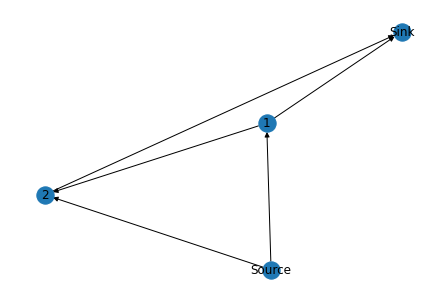

In [138]:
nx.draw(G,with_labels = True)

In [141]:
prob.solve(time_limit=60) 

TypeError: solve() got an unexpected keyword argument 'direction'

In [140]:
print("Best routes: ", prob.best_routes)
print("Route departure: ", prob.departure_time)
print("Route cost: ", prob.best_routes_cost)
print("Route type: ", prob.best_routes_type )
print("Route arrival: ", prob.arrival_time)
print("Route Load: ", prob.best_routes_load)

Best routes:  {1: ['Source', 1, 'Sink'], 2: ['Source', 2, 'Sink']}
Route departure:  {1: {'Source': 0, 1: 5, 'Sink': 5}, 2: {'Source': 0, 2: 5, 'Sink': 5}}
Route cost:  {1: 10, 2: 10}
Route type:  {1: 0, 2: 0}
Route arrival:  {1: {'Source': 0, 1: 0, 'Sink': 5}, 2: {'Source': 0, 2: 0, 'Sink': 5}}
Route Load:  {1: 8, 2: 8}
